# 서포트 벡터 머신

아이디어: 두 집단 모두에게서 가장 멀리 떨어진 경계선을 만드는 것<br>
특징
- 클래스 간 가장 거리가 가까운 샘플(>>> 서포트 벡터)에 의해 경계 결정
- 서포트 벡터 바깥쪽에 샘플을 추가해도 경계 모양이 변하지는 않음
- 특성 스케일에 민감함

### 소프트 마진 분류

- 하드 마진 분류
    - 모든 샘플이 경계 바깥쪽으로 딱! 분류된 경우
    - 한계
        1. 선형적으로 구분되야 함
        2. 이상치에 민감하다 (돌출부, 특이값 ... ) <br>
        \>>> 때문에 샘플 사이의 거리를 가능한 넓게 하는 것과 마진 오류 사이의 균형을 잡아야 함

- 소프트 마진 분류
    - 샘플 사이의 거리를 가능한 넓게 하는 것과 마진 오류 사이의 균형을 잡은 방식
    - 사이킷런의 SVM에선 하이퍼파리미터 C를 사용해 균형 조절
    

C?
- 결정 경계를 얼마나 좁게 잡을지 조절하는 하이퍼파라미터
- 커질 수록 좁은 마진 >>> 확실하게 분류할 수 있지만 일반화 정도가 떨어질 수 있다 ( == 과대적합)
- 작을 수록 넓은 마진 >>> 일반화는 잘 되지만 정확도, 재현률은 떨어질 수 있다 ( == 과소적합)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'batang'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
""" SVM 구현 """

import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][ : , (2, 3)] # 꽃잎 길이 & 너비
y = (iris["target"] == 2).astype(np.float64) # virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [3]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

LinearSVC는 클래스에 대한 확률은 제공하지 않는다. (즉 predict_proba는 기본 미제공)<br>
단, probability=True 지정 시 predict_proba를 사용 가능하다

#### 다른 SVM 구현 방법

1. SVC(kernel="linear", C=1)
2. SGDClassifier(loss="hinge", alpha=1/(m\*C): 데이터셋이 아주 큰 경우 & 온라인 학습 시 적합<br>
<br>

다시 한 번 강조하지만 SGDClassifier / regressor는 모델을 직접 만드는 것이 아니라, 최적 파라미터를 찾아내는 방법이다

LinearSVC는 규제에 편향을 포함시킨다<br>
그래서 훈련 세트에서 평균을 빼 중앙에 맞춰야 한다<br>
StandardScaler를 사용하면 알아서 이렇게 해준다<br>
LinearSVC는 규제에 편향을 포함하고 있기에 그냥 하면 차이가 발생한다.<br>
+ loss="hinge"로 해야 한다 (기본 "squared_hinge")
+ 훈련 샘플보다 특성이 많지 않다면 성능 향상을 위해 dual=False로 해야 함

# 비선형 SVM 분류

In [4]:
"""PolynomialFeatures + StandardScaler + LinearSVC 조합 >>> Pipeline"""

from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

C:\Users\rksla\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

### 방법 1. 다항식 커널: 커널 트릭을 이용한 방식

커널 트릭?
- 특성을 추가하지 않으면서 다항식 특성을 추가한 것과 같은 결과를 얻을 수 있게 하는 기법
- 실제 특성을 추가하는 것이 아니기 때문에 PolynomialFeatures 이용 시 조합이 많이 생기지 않음

In [5]:
"""
커널 트릭 예시: kernel='poly'

    degree: 경계 차수, 여기선 3차
    coef0: 
        다항식 커널의 상수항 r (기본 0).
        차수가 높을 수록 계수에 의해서도 값의 차이가 커질 수 있기 때문에 coef0로 고차항의 영향력 조정
        
    *** 적절한 하이퍼파라미터 조합은 GridSearch 활용을 통해 찾을 수 있다
"""

from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [6]:
""" 10차 + 상수항 100 """

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

In [7]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

In [8]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

Text(0.5, 1.0, '$d=10, r=100, C=5$')

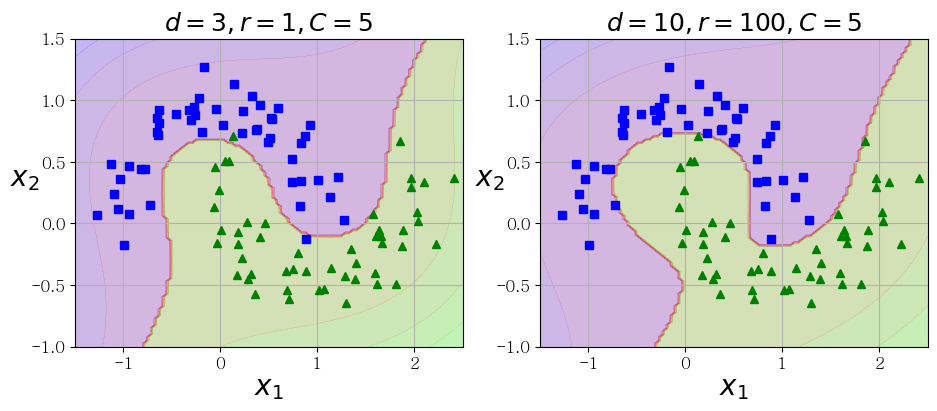

In [9]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

### 방법 2. 유사도 특성 추가

상세
- 특정 샘플 x를 기준으로 했을 때 다른 샘플들은 x와 얼마나 비슷한지를 계산해 이를 새 특성으로 추가하는 방식. 이 때
    - x를 랜드마크 라고 하며
    - 얼마나 비슷한지 계산하는 방법을 유사도 함수 라고 한다
- 랜드마크 선정은 그냥 모든 샘플을 선택하는 방식이다
- 차원이 매우 커지고, 경우에 따라 변환 결과가 선형적으로 구분될 가능성이 높아진다
- 단점은 n개의 특성을 가진 m개의 샘플이 m개의 특성을 가진 m개의 샘플로 변환된다는 것이다.

### 가우시안 RBF 커널: 유사도 X 커널 트릭

유사도를 이용해 훈련셋을 변환할 경우 훈련셋 shape은 $nm$ >>> $m^2$로 바뀌며 이는 샘플 수가 많아질 경우 문제가 될 수 있다 <br>
\>>> 가우시안 RBF 커널 활용<br>
\* 가우시안 RBF는 다음 식으로 나타내며, 값이 0~1 사이인 종 모양인 함수다<br>
> $\phi_{\gamma}(\mathbf{x}, l) = \exp(-\gamma {\begin {Vmatrix} \mathbf{x} - l \end {Vmatrix}}^2)$


In [16]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [17]:
rbf_kernel_svm_clf_C1000 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=1000))
])

rbf_kernel_svm_clf_C1000.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1000, gamma=5))])

In [18]:
rbf_kernel_svm_clf_g01_C0001 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.1, C=0.001))
])

rbf_kernel_svm_clf_g01_C0001.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=0.1))])

In [19]:
rbf_kernel_svm_clf_g01_C1000 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.1, C=1000))
])

rbf_kernel_svm_clf_g01_C1000.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.1))])

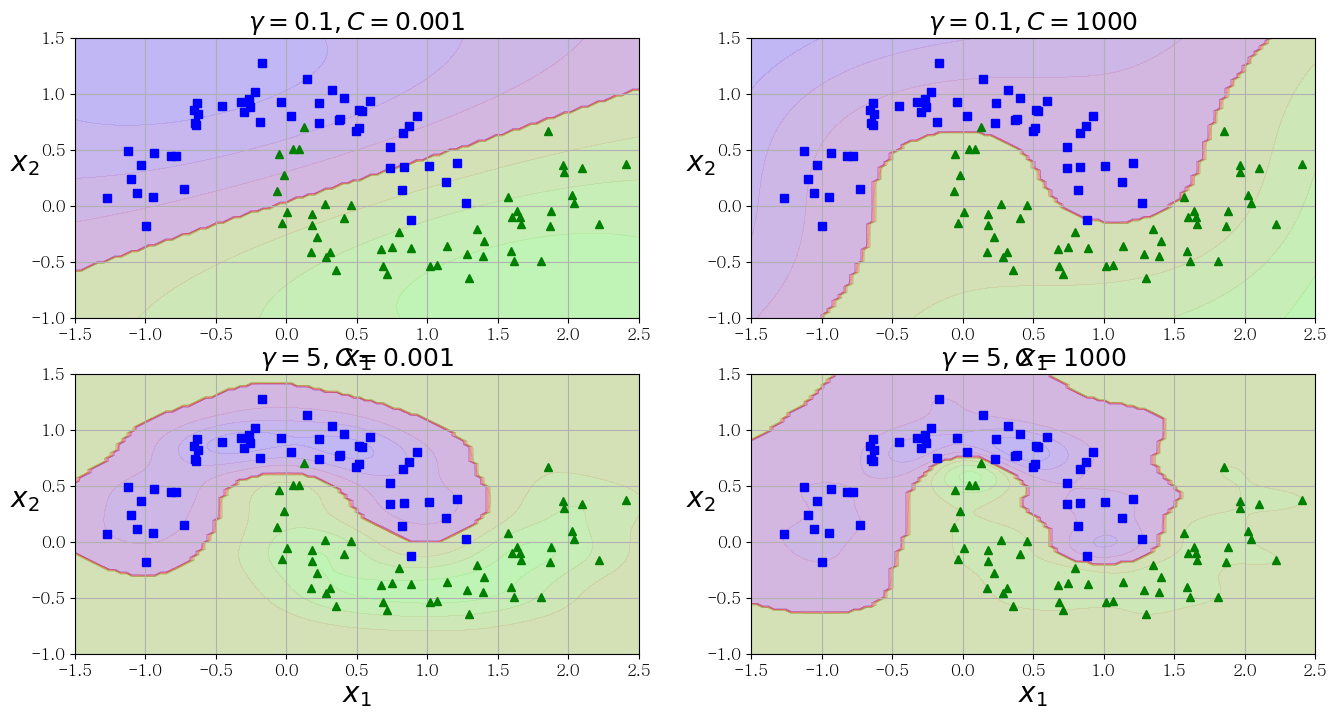

In [20]:
plt.figure(figsize=(16, 8))

plt.subplot(221)
plot_predictions(rbf_kernel_svm_clf_g01_C0001, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$γ=0.1, C=0.001$", fontsize=18)

plt.subplot(222)
plot_predictions(rbf_kernel_svm_clf_g01_C1000, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$γ=0.1, C=1000$", fontsize=18)

plt.subplot(223)
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$γ=5, C=0.001$", fontsize=18)

plt.subplot(224)
plot_predictions(rbf_kernel_svm_clf_C1000, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$γ=5, C=1000$", fontsize=18)

plt.show()

결과 분석<br>
- $\gamma$가 커질 수록 RBF의 모양은 급격해진다. 즉 $\gamma$는 비슷한 샘플끼리 뭉치게 하는 하이퍼파라미터 역할을 한다

#### SVM 모델 구축 시 고려사항

1. 하이퍼파라미터 $\gamma$, C로 규제를 추가 / 완화할 수 있다
    - $\gamma$: 얼마나 비슷해야 하는지 설정. 작을 수록 규제 완화 (덜 비슷해도 같은 클래스로 포함)
    - C: 경계를 얼마나 엄격하게 할 것인지 설정. 작을 수록 규제 완화
2. 커널 선택
    1. 선형 커널 먼저 시도 (특히 훈련 세트 / 특성이 아주 많을 때)
    2. 훈련 세트가 너무 크지 않다면 가우시안RBF (대부분 잘 맞음)
    3. 교차 검증 / 그리드 탐색으로 최적 커널 탐색

### 계산 복잡도

# SVM 회귀

In [15]:
""" 선형 SVR 구현 """

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5)

### 비선형 SVR

In [16]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

# SVM 이론

표기 정리 (좀 더 일반적인 표현)
- b: 편향 (즉 상수항)
- $\mathbf {w}$: 편향을 제외한 특성의 가중치 벡터

### 결정 함수와 예측

선형 SVM 분류기 모델은 결정 함수 $h = \mathbf{w}^T \cdot \mathbf{x} + b = w_1x_1+...w_nx_n$를 계산해 새로운 샘플의 클래스를 예측하는 방식<br>
이 때 <br>
$\hat{y}=
\begin {cases}
0 \mbox{ (when } \mathbf{w}^T \cdot \mathbf{x}+b \lt 0\mbox{)} \\
1 \mbox{ (when } \mathbf{w}^T \cdot \mathbf{x}+b \geq 0\mbox{)} \\
\end {cases}
$

<br>
선형 SVM 분류기를 훈련한다는 것은<br>
마진 오류를 하나도 발생시키지 않거나 (하드 마진)<br>
제한적인 마진 오류를 가지면서 (소프트 마진)<br>
가능한 마진을 크게 하는 bold w, b를 찾는 것이다

### 목적 함수

결정 함수의 기울기는 가중치 벡터 $\begin {Vmatrix} \mathbf{w} \end {Vmatrix}$의 노름과 같다 (==l2 노름)<br>
이 기울기를 2로 나누면 결정 함수 마진의 최대/최소 범위가 결정 경계 (~원래 결정 함수)로부터 2배만큼 멀어진다<br>
즉 (기울기 / 2)는 (마진 * 2)와 같은 효과를 내며 이 때<br>
$\mathbf{w}$가 작을수록 마진은 커진다

#### 하드 마진의 경우

SVM을 이용한 분류는 결정 경계와 클래스 집단 사이의 거리를 최대한 벌리는것이 목표<br>
\>>> == 마진을 최대한 크게 하는 것<br>
\>>> $\begin {Vmatrix} \mathbf{w} \end {Vmatrix}$를 최소화하는 것<br>
<br>
이 때, 마진 오류를 하나도 만들지 않으려면 (즉, 하드 마진이라면) 모든 샘플에 대해 결정함수의 값이 마진보다 크거나(양성) 작아야 한다(음성) >>> 조건<br>
여기서
- 음성 샘플일 때 (즉 $y^{(i)}=0$일 때) $t^{(i)} = -1$ (h=0로부터 음의 방향으로의 거리)
- 양성 샘플일 때 (즉 $y^{(i)}=1$일 때) $t^{(i)} = 1$ (h=0로부터 양의 방향으로의 거리)
라고 정의하면
위에서 말한 "조건"은 모든 샘플에 대해 다음과 같이 표현할 수 있다<br>
> $t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)}+b) \geq 1$<br>

이 때
- 1: ~ 마진 (편하게 1로 잡아둔 것)
- $t^{(i)}=1$일 경우 양성 샘플로 분류했다는 의미이기에 $\mathbf{w}^T \cdot \mathbf{x}^{(i)}+b$ (==결정함수 값) $ \geq 1$이다
- $t^{(i)}=-1$일 경우 음성 샘플로 분류했다는 의미이기에 $(\mathbf{w}^T \cdot \mathbf{x}^{(i)}+b) \leq -1$이다
- $\left|1\right|$보다 큰 이유는 하드 마진 분류라 결과가 마진보다 커야 하기 때문이다
    
<br>
그러므로 하드 마진 선형 SVM 분류기의 목적 함수를 다음과 같은 제약이 있는 최적화 문제로 표현할 수 있다

> minimize$(\mathbf{w}, b)$ from ${1\over2} \mathbf{w}^T \cdot \mathbf{w}$ (즉 ${1\over2} \mathbf{w}^T \cdot \mathbf{w}$를 최소화하는 ($\mathbf{w}, b$)를 찾아내는 것)<br>
이 때<br>
    - i: 1 ~ m일 $t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)}+b) \geq 1$일 것

???: $\vert\vert \mathbf{w} \vert\vert$ 말고 ${1\over2}\mathbf{w}^T \cdot \mathbf{w}$를 최소화한다?
1. 결과는 같지만 더 다루기 쉽다 ($\left|\mathbf{w}\right|$의 치환 형태, ${1\over2}\mathbf{w}^T \cdot \mathbf{w} = {1\over2} { \vert\vert \mathbf{w} \vert\vert }^2$)
2. 최적화 함수는 미분 가능한 형태에서 잘 작동하는데 $\left|\mathbf{w}\right|$는 $\mathbf{w}$ = 0에서 미분 불가능하다 

#### 소프트 마진의 경우

목적함수를 구성하기 위해 각 샘플에 대해 슬랙 변수 $\zeta^{(i)} \geq 0$을 도입한다<br>
$\zeta^{(i)}$?
- i번째 샘플이 얼마나 마진을 위반할지 정하는 것
- 음성 샘플이라면 h=0으로부터 음의 거리만큼 떨어진 마진에서 얼마나 위로 올라갈지 정함
- 양성 샘플이라면 그 반대

소프트마진의 목표
- 조건 1. (하드 마진과 똑같이) 1/2 bold wT dot bold w를 최소화해야 한다 >>> $\mathbf{w}, b$ 최적화
- 조건 2. 마진 오류까지 최소화해야 한다 >>> $\zeta^{(i)}$ 최소화, C 최적화

<br>
위 두 조건을 모두 표현할 수 있도록 식으로 표현하면 다음과 같다<br>

> minimize$(\mathbf{w}, b, \zeta)$ from $({1\over2} \mathbf{w}^T \cdot \mathbf{w} + C\sum_{i=1}^m \zeta^{(i)})$<br>

이 때
- i: 1 ~ m일 때 $t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)}+b) \geq 1-\zeta^{(i)}$고
- $\zeta^{(i)} \geq 0$일 것

해설
- C를 크게 하면서 기울기는 그대로 하려면? >>> $\sum_{i=1}^m \zeta^{(i)}$가 작아야 가능. 즉 마진 오차가 작아야 가능
- C를 작게 하면서 기울기는 그대로 하려면? >>> $\sum_{i=1}^m \zeta^{(i)}$가 커야 가능.
- $C \sum_{i=1}^m \zeta^{(i)}$가 커진다면? >>> 기울기를 줄일 수 있는 여유가 줄어들어 기존보다 h가 급격해짐
- $C \sum_{i=1}^m \zeta^{(i)}$가 작아진다면? >>> 기울기를 줄일 수 있는 한도가 늘어나 기존보다 h가 완만해짐

#### SVM 회귀의 경우

SVM 회귀는 마진 안에 최대한 많은 샘플을 담는 것이 목표이므로<br>
결정 경계의 양쪽의 오차 폭을 두 개의 슬랙 변수 $\zeta, \zeta^*$ 라고 할 때, 다음을 만족하도록 목적함수를 구성한다
> 1. $y^{(i)} - (\mathbf{w}^T \cdot \mathbf{x}^{(i)} + b) \leq \varepsilon + \zeta^{(i)}$
> 2. $ - y^{(i)} + (\mathbf{w}^T \cdot \mathbf{x}^{(i)} + b) \leq  \varepsilon + \zeta^{(i)*}$

<br>
를 만족하는 목적 함수를 구성한다.<br>
이 때

- $\varepsilon$: ~ 마진

### 콰드라틱 프로그래밍

QP는 쉽게 말해 이차함수 최적화<br>
갑자기 웬 QP?<br>
\>>> 하드 마진, 소프트 마진 둘 다 선형적인 제약 조건이 있는 볼록 함수의 이차 최적화 문제이기 때문에 QP 문제
일반적인 형태
> minimize($\mathbf{p}$) from ${1\over2} \mathbf{p}^T \cdot \mathbf{H} \cdot \mathbf{p} + \mathbf{f}^T \cdot \mathbf{p}$

여기서
- $\mathbf{A} \cdot \mathbf{p} \leq \mathbf{b}$일 것
- $\mathbf{p}$: $n_p$ 차원의 벡터
- $n_p$: 모델 파라미터 수
- $\mathbf{H}$: $n_p \times n_p$ 크기 행렬
- $\mathbf{f}$: $n_p$ 차원의 벡터
- $\mathbf{A}$: $n_c \times n_p$ 크기 행렬
- $n_c$: 제약 수
- $\mathbf{b}$: $n_c$ 차원의 벡터

위의 내용을 좀 더 살펴보면
- ${1\over2} \mathbf{p}^T \cdot \mathbf{H} \cdot \mathbf{p}$: ~ ${1\over2} \mathbf{w}^T \cdot \mathbf{w}$
- $\mathbf{f}^T \cdot \mathbf{p}$: ~ $C\sum_{i=1}^m \zeta^{(i)}$
- $\mathbf{A} \cdot \mathbf{p} \leq \mathbf{b}$: ~ $t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)}+b) \geq 1-\zeta^{(i)}$

와 비슷하다

$\mathbf{A}\cdot\mathbf{b} \leq \mathbf{b}$는 다음과 같은 $n_c$개의 제약을 정의하는 것과 같다 <br>
> $\mathbf{p}^T \cdot \mathbf{a}^{(i)} \leq b^{(i)}$ (i: 1 ~ $n_c$ >>> 위의 3번째 내용과 비슷하다)

이 때
- $\mathbf{a}^{(i)}$: $\mathbf{A}$의 i번째 행벡터 (~ $\mathbf{x}^{(i)}$)
- $b^{(i)}$: $\mathbf{b}$의 i번째 원소

#### 하드 마진 선형 SVM에서의 검증 방법

1. $n_p$ = n + 1 (n: 특성 수. +1은 편향)
2. $n_c$ = m (m: 훈련 샘플 수)
3. $\mathbf{H}$ = 왼쪽 맨 위의 원소가 0인 $n_p \times n_p$ 크기 단위행렬 (편향을 제외하기 위해 0)
4. $\mathbf{f}$ = 모두 0으로 채워진 $n_p$ 차원의 벡터
5. $\mathbf{b}$ = 모두 1로 채워진 $n_c$ 차원의 벡터
6. $a^{(i)}$ = $-t^{(i)} \dot{\mathbf{x}}^{(i)}$ (여기서 $\dot{\mathbf{x}}^{(i)}$는 $\mathbf{x}^{(i)}$에 편향 ($\dot{\mathbf{x}}_0=1$)을 추가한 것. ~ (~ $\mathbf{x}^{(i)}+b$)) 

저렇게 설정한 이유
- 하드 마진은 슬랙 변수가 없기 때문이다
    - 4 >>> 전부 0이라 곱하면 슬랙 변수 항 nullify
    - 5 >>> 슬랙 변수가 포함되면 안되기 때문에 1로만 채워넣은 것

저들을 그대로 전달해서 $\mathbf{p}$를 찾아내는 방법도 하드 마진 선형 SVM 분류기를 훈련시키는 방법 중 하나일 수 있다
결과 벡터 $\mathbf{p}$는 편향 $b=p_0$와 특성 가중치 $w^{(i)}=p^{(i)}$ (i: 1 ~ m)를 담고 있다

#### 소프트 마진 문제에서도 QP 알고리즘을 사용하려면? (내가 한 건 틀렸다. 부록 참조)

In [22]:
f = np.arange(1, 4)
p = np.arange(1, 20, 7)
f, p

(array([1, 2, 3]), array([ 1,  8, 15]))

In [23]:
np.dot(f.T, p)

62

In [24]:
np.dot(p.T, f)

62

하지만 커널 트릭을 사용하려면 제약이 있는 최적화 문제를 다른 형태로 바꿔야 한다?

### 쌍대 문제

### 커널 SVM

$\mathbf{\hat{w}} = \sum_{i=1}^m \hat{\alpha}^i t^i x^i $ <br>

### 온라인 SVM